# Autoencoder for uninfected malaria cell images

## Imports

In [1]:
import os
import glob
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

In [2]:
tf.__version__

'2.3.0'

In [3]:
tf.get_logger().setLevel('ERROR')

### Check for GPU

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Constants

In [5]:
RANDOM_STATE = 7
BASE_PATH = r"D:\Programming\Datasets\Malaria Cell Images\Uninfected"
IMAGE_SIZE = (128, 128)
VAL_SIZE = 0.05
BATCH_SIZE = 32
EPOCHS = 10

## Data Loading

In [6]:
imageNames = [os.path.basename(file) for file in glob.glob(os.path.join(BASE_PATH, '*.png'))]

print(f"\nTotal number of image files: {len(imageNames)}")


Total number of image files: 13779


In [7]:
%%time

imageData = []

for name in tqdm(imageNames, desc = 'Loading image data', unit = ' images'):
    img = load_img(os.path.join(BASE_PATH, name))
    img = tf.image.resize_with_pad(img_to_array(img, dtype = 'uint8'), *IMAGE_SIZE).numpy().astype('uint8')
    imageData.append(img)
    
imageData = np.array(imageData)
imageData = imageData/255.0
imageData.shape

Loading image data: 100%|██████████| 13779/13779 [01:23<00:00, 164.92 images/s]
Wall time: 1min 25s


(13779, 128, 128, 3)

In [8]:
imageData.min(), imageData.max()

(0.0, 1.0)

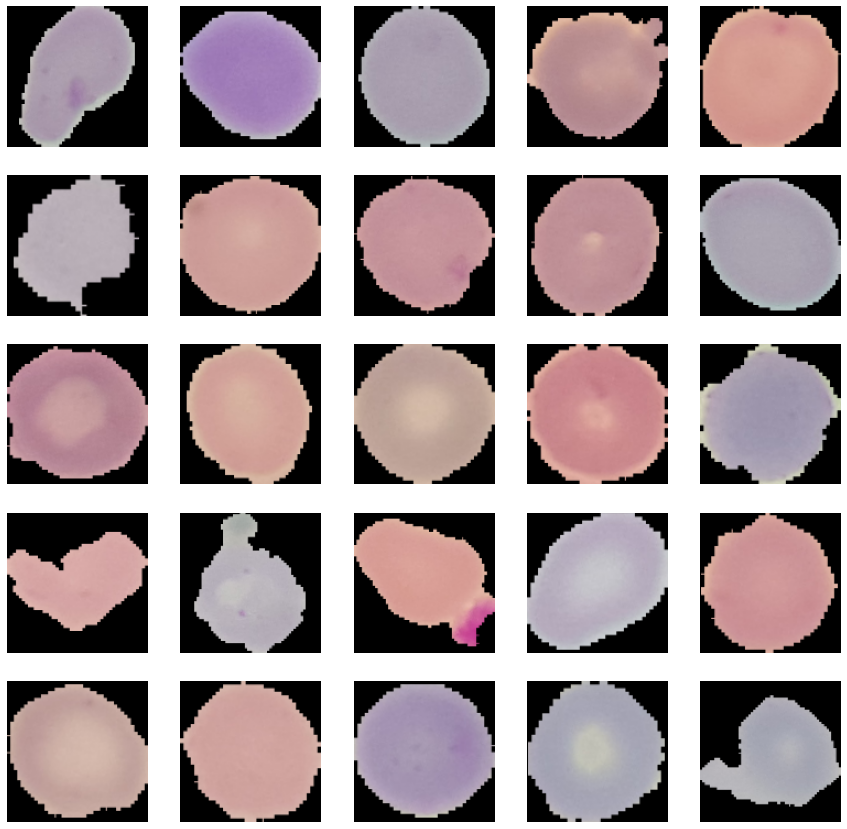

In [9]:
plt.subplots(nrows = 5, ncols = 5, figsize = (15, 15))

for i, imgIndex in enumerate(np.random.randint(0, len(imageNames), size = 25)):
  plt.subplot(5, 5, i + 1)
  plt.axis(False)
  plt.grid(False)
  plt.imshow(imageData[imgIndex])
plt.show()

In [10]:
X_train, X_val = train_test_split(
    imageData, 
    test_size = VAL_SIZE, 
    random_state = RANDOM_STATE
    )

print(f'Training Data: {X_train.shape}')
print(f'\nValidation Data: {X_val.shape}')

Training Data: (13090, 128, 128, 3)

Validation Data: (689, 128, 128, 3)


In [11]:
del imageData

In [12]:
inputLayer = Input(shape = (*IMAGE_SIZE, 3), name = 'Input')

In [13]:
conv_1 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(inputLayer)
pool_1 = MaxPooling2D((4, 4), padding = 'same')(conv_1)
pool_1.shape

TensorShape([None, 32, 32, 8])

In [14]:
conv_2 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(pool_1)
pool_2 = MaxPooling2D((4, 4), padding = 'same')(conv_2)
pool_2.shape

TensorShape([None, 8, 8, 16])

In [15]:
conv_3 = Conv2D(32, (2, 2), activation = 'relu', padding = 'same')(pool_2)
pool_3 = MaxPooling2D((2, 2), padding = 'same')(conv_3)
pool_3.shape

TensorShape([None, 4, 4, 32])

In [16]:
conv_4 = Conv2D(64, (2, 2), activation = 'relu', padding = 'same')(pool_3)
pool_4 = MaxPooling2D((2, 2), padding = 'same')(conv_4)
pool_4.shape

TensorShape([None, 2, 2, 64])

In [17]:
conv_5 = Conv2D(64, (2, 2), activation = 'relu', padding = 'same')(pool_4)
up_1 = UpSampling2D((2, 2))(conv_5)
up_1.shape

TensorShape([None, 4, 4, 64])

In [18]:
conv_6 = Conv2D(32, (2, 2), activation = 'relu', padding = 'same')(up_1)
up_2 = UpSampling2D((2, 2))(conv_6)
up_2.shape

TensorShape([None, 8, 8, 32])

In [19]:
conv_7 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(up_2)
up_3 = UpSampling2D((4, 4))(conv_7)
up_3.shape

TensorShape([None, 32, 32, 16])

In [20]:
conv_8 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(up_3)
up_4 = UpSampling2D((4, 4))(conv_8)
up_4.shape

TensorShape([None, 128, 128, 8])

In [21]:
outputLayer = Conv2D(3, (3, 3), activation = 'sigmoid', padding = 'same', name = 'Output')(up_4)
outputLayer.shape

TensorShape([None, 128, 128, 3])

In [22]:
autoencoder = Model(inputs = inputLayer, outputs = outputLayer)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

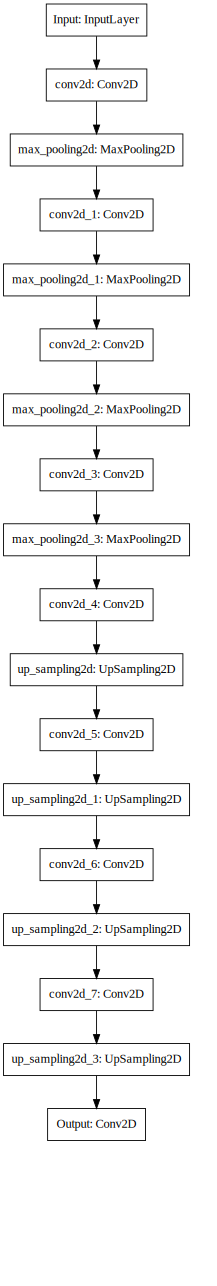

In [23]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(autoencoder, dpi=64).create(prog='dot', format='svg'))

In [24]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)         

In [25]:
history = autoencoder.fit(X_train, X_train, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 1, validation_data = (X_val, X_val))

Epoch 1/10
410/410 [==============================] - 12s 30ms/step - loss: 0.5015 - val_loss: 0.4686
Epoch 2/10
410/410 [==============================] - 10s 26ms/step - loss: 0.4636 - val_loss: 0.4885
Epoch 3/10
410/410 [==============================] - 10s 25ms/step - loss: 0.4585 - val_loss: 0.4558
Epoch 4/10
410/410 [==============================] - 10s 25ms/step - loss: 0.4530 - val_loss: 0.4533
Epoch 5/10
410/410 [==============================] - 10s 25ms/step - loss: 0.4509 - val_loss: 0.4514
Epoch 6/10
410/410 [==============================] - 10s 25ms/step - loss: 0.4490 - val_loss: 0.4509
Epoch 7/10
410/410 [==============================] - 10s 25ms/step - loss: 0.4480 - val_loss: 0.4491
Epoch 8/10
410/410 [==============================] - 10s 25ms/step - loss: 0.4471 - val_loss: 0.4488
Epoch 9/10
410/410 [==============================] - 10s 25ms/step - loss: 0.4465 - val_loss: 0.4498
Epoch 10/10
410/410 [==============================] - 10s 25ms/step - loss: 0.445

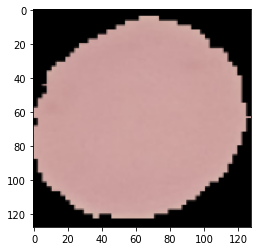

In [30]:
test = X_val[7:8]
plt.imshow(test[0])

In [32]:
pred = autoencoder.predict(test)

In [31]:
test.shape

(1, 128, 128, 3)

In [33]:
pred.shape

(1, 128, 128, 3)

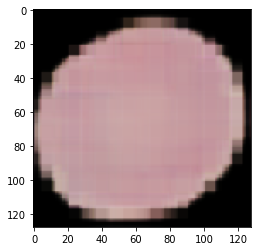

In [34]:
plt.imshow(pred[0])

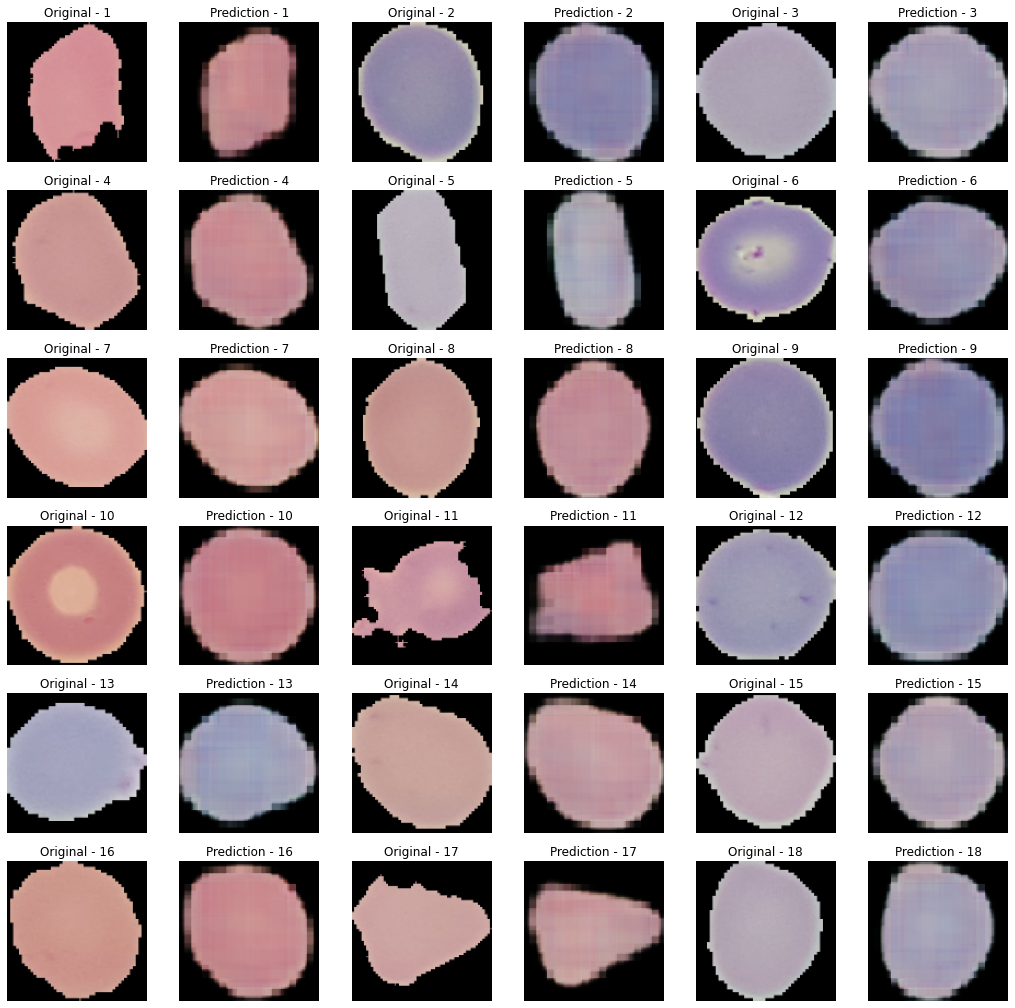

In [49]:
plt.subplots(nrows = 6, ncols = 6, figsize = (18, 18))

val_data = X_val[np.random.randint(0, len(X_val), size = 18)]
pred = autoencoder.predict(val_data)

for i in range(len(val_data)):
  plt.subplot(6, 6, (2 * i) + 1)
  plt.axis(False)
  plt.grid(False)
  plt.title(f"Original - {i + 1}")
  plt.imshow(val_data[i])

  plt.subplot(6, 6, (2 * i) + 2)
  plt.axis(False)
  plt.grid(False)
  plt.title(f"Prediction - {i + 1}")
  plt.imshow(pred[i])
plt.show()